{/* cspell:ignore yticks hspace VQCs linesize, imshow, minpos, nonumber, zzcircuit, zcircuit, pcircuit, zzcx, Schuld, Francesco, Peruccione, Vojtech, Adrian, Perez, Cervera, Lierta, Elies, Fuster, Jose, Latorre, Sweke, Jakob */}

# Quantum Variational Circuits and Quantum Neural Networks

In this lesson, we implement several variational quantum circuits for a data classification task, so-called variational quantum classifiers (VQCs). At one point, it was common to refer to a subset of VQCs as quantum neural networks (QNNs) in analogy with classical neural networks. Indeed, there are cases where structures borrowed from classical neural networks, such as convolution layers, play an important role in VQCs. In such cases where the analogy is strong, QNNs may be a useful description. But parameterized quantum circuits need not follow the general structure of a neural network; for example, not all data need to be loaded in the first (input) layer; we can load some data in the first layer, apply some gates and then load additional data (a process called data "reuploading"). We should therefore think of QNNs as a subset of parameterized quantum circuits, and we should not be limited in our exploration of useful quantum circuits by the analogy to classical neural networks.

The dataset being addressed in this lesson consists of images containing horizontal and vertical stripes, and our goal is to label unseen images into one of the two categories depending on the orientation of their line. We will accomplish this with a VQC. As we go, we will address ways in which the calculation can be improved and scaled. The dataset here is exceptionally easy to classify classically. It has been chosen for its simplicity so we can focus on the quantum part of this problem, and look at how a dataset attribute might translate to a part of a quantum circuit. It is not reasonable to expect a quantum speed-up for such simple cases where classical algorithms are so efficient.

By the end of this lesson you should be able to:

*   Load data from an image into a quantum circuit
*   Construct an ansatz for a VQC (or QNN), and adjust it to fit your problem
*   Train your VQC/QNN and use it to make accurate predictions on test data
*   Scale the problem, and recognize limits of current quantum computers



## Data generation

We will start by constructing the data. Data sets are often not explicitly generated as part of the Qiskit patterns framework. But data type and preparation is critical to successfully applying quantum computing to machine learning. The code below defines a data set of images with set pixel dimensions. One full row or column of the image is assigned the value $\pi/2$, and the remaining pixels are assigned random values on the interval $(0,\pi/4)$. The random values are noise in our data. Glance through the code to make sure you understand how the images are generated. Later on we will scale up the images.



In [9]:
# This code defines the images to be classified:

import numpy as np

# Total number of "pixels"/qubits
size = 8
# One dimension of the image (called vertical, but it doesn't matter). Must be a divisor of `size`
vert_size = 2
# The length of the line to be detected (yellow). Must be less than or equal to the smallest dimension of the image (`<=min(vert_size,size/vert_size)`
line_size = 2


def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((size - (line_size - 1) * vert_size, size))
    ver_array = np.zeros((round(size / vert_size) * (vert_size - line_size + 1), size))

    j = 0
    for i in range(0, size - 1):
        if i % (size / vert_size) <= (size / vert_size) - line_size:
            for p in range(0, line_size):
                hor_array[j][i + p] = np.pi / 2
            j += 1

    # Make two adjacent entries pi/2, then move down to the next row. Careful to avoid the "pixels" at size/vert_size - linesize, because we want to fold this list into a grid.

    j = 0
    for i in range(0, round(size / vert_size) * (vert_size - line_size + 1)):
        for p in range(0, line_size):
            ver_array[j][i + p * round(size / vert_size)] = np.pi / 2
        j += 1

    # Make entries pi/2, spaced by the length/rows, so that when folded, the entries appear on top of each other.

    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, len(hor_array))
            images.append(np.array(hor_array[random_image]))

        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, len(ver_array))
            images.append(np.array(ver_array[random_image]))
            # Randomly select 0 or 1 for a horizontal or vertical array, assign the corresponding label.

        # Create noise
        for i in range(size):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels


hor_size = round(size / vert_size)

Note that the code above has also generated labels indicated whether the images contain a vertical (+1) or horizontal (-1) line. We will now use sklearn to split a data set of 100 images into a training and testing set (along with their corresponding labels). Here, we use $70%$ of the data set for training, with the remaining $30%$ withheld for testing.



In [10]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
images, labels = generate_dataset(200)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

Let's plot a few elements of our data set to see what these lines look like:



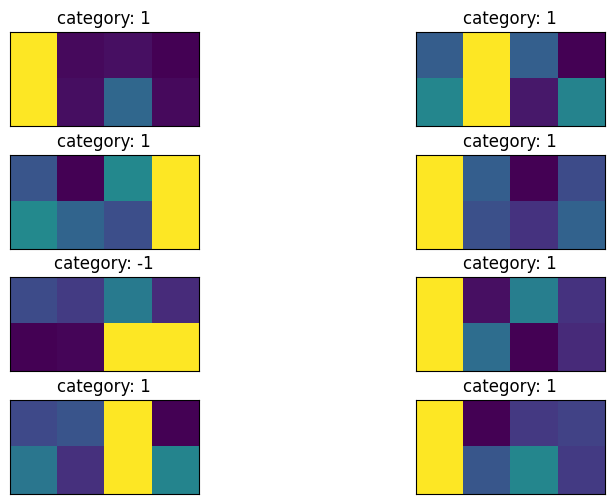

In [3]:
import matplotlib.pyplot as plt

# Make subplot titles so we can identify categories
titles = []
for i in range(8):
    title = "category: " + str(train_labels[i])
    titles.append(title)

# Generate a figure with nested images using subplots.
fig, ax = plt.subplots(4, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})

for i in range(8):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
    ax[i // 2, i % 2].set_title(titles[i])
plt.subplots_adjust(wspace=0.1, hspace=0.3)

Each of these images is still paired with its label in `train_labels` in a simple list form:



In [11]:
print(train_labels[:8])

[1, 1, 1, 1, -1, 1, 1, 1]


## Variational quantum classifier: a first attempt

### Qiskit patterns step 1: Map the problem to a quantum circuit

The goal is to find a function $f$ with parameters $\theta$ that maps a data vector / image $\vec{x}$ to the correct category: $f_\theta(\vec{x}) \rightarrow \pm1$. This will be accomplished using a VQC with few layers that can be identified by their distinct purposes:

$$
f_\theta(\vec{x}) = \langle 0|U^{\dagger}(\vec{x})W^\dagger(\theta)OW(\theta)U(\vec{x})|0\rangle
$$

Here, $U(\vec{x})$ is the encoding circuit, for which we have many options as seen in previous lessons. $W(\theta)$ is a variational, or trainable circuit block, and $\theta$ is the set of parameters to be trained. Those parameters will be varied by classical optimization algorithms to find the set of parameters that yields the best classification of images by the quantum circuit. This variational circuit is sometimes called the "ansatz". Finally, $O$ is some observable that will be estimated using the Estimator primitive. There is no constraint that forces the layers to come in this order, or even to be fully separate. One could have multiple variational and/or encoding layers in any order that is technically motivated.

We start by choosing a feature map to encode our data. We will use the `z_feature_map`, as it keeps circuit depths low compared to some other feature mappings.



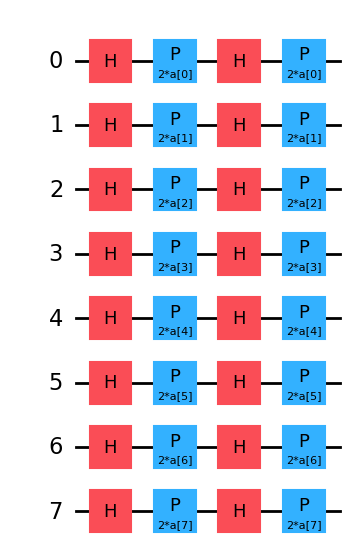

In [13]:
from qiskit.circuit.library import z_feature_map

# One qubit per data feature
num_qubits = len(train_images[0])

# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = z_feature_map(num_qubits, parameter_prefix="a")

feature_map.draw("mpl")

We must now decide on an ansatz to be trained. There are many considerations when selecting an ansatz. A complete description is beyond the scope of this introduction; here we simply point out a few categories of considerations.

1.  **Hardware:** All modern quantum computers are more prone to errors and more susceptible to noise than their classical counterparts. Using an ansatz that is excessively deep (especially in transpiled, two-qubit depth) will not produce good results. A related issue is that quantum computers have some qubit layout, meaning that some physical qubits are adjacent on the quantum computer, and others may be very far from each other. Entangling adjacent qubits does not increase the depth by too much, but entangling very distant qubits can increase depth substantially, as we must insert swap gates to move information onto qubits that are adjacent in order for them to be entangled.
2.  **The problem:** Whenever you have some information about your problem that could guide your ansatz, make use of it. For example, the data in this lesson is made up of images of horizontal and vertical lines. One could consider what correlation between adjacent colors/values identifies an image of a horizontal or vertical line. What attributes of an ansatz would correspond to this correlation between adjacent pixels? We will revisit this point more technically later in this lesson. But for now, let us simply say that including entanglement and CNOT gates between qubits corresponding to adjacent pixels seems like a good idea. In the bigger picture, consider whether the problem is actually best solved using a quantum circuit, or whether classical algorithms might exist that can do as good a job.
3.  **Number of parameters:** Each independently parameterized quantum gate in the circuit increases the space to be classically optimized, and this results in slower convergence. But as problems scale up, one may encounter *barren plateaus*. This term refers to a phenomenon where the optimization landscape of a variational quantum algorithm becomes exponentially flat and featureless as the problem size increases. This causes vanishing gradients, making it difficult to effectively train the algorithm[\[1\]](#references). Barren plateaus are relevant to variational quantum algorithms like VQCs/QNNs. It should be noted that the increasing number of parameters is not the only consideration in avoiding barren plateaus; other considerations include global cost functions and random parameter initialization.

In this lesson we will see a few simple examples of good practices in ansatz construction. Let us first try the ansatz below. We will return to revise it, later.



5
2+ qubit depth: 3


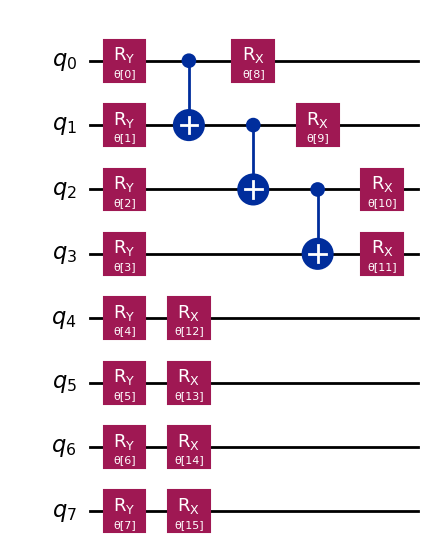

In [6]:
# Import the necessary packages
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)

# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * size)

# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)

# Here is a list of qubit pairs between which we want CNOT gates. The choice of these is not yet obvious.
qnn_cnot_list = [[0, 1], [1, 2], [2, 3]]

for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])

# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size + i], i)

# Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)

# Draw the circuit
qnn_circuit.draw("mpl")

With the data encoding and variational circuit prepared, we can combine them to form our full ansatz. In this case, the components of our quantum circuit are quite analogous to those in neural networks, with $U(\vec{x})$ being most similar to the layer that loads input values from the image, and $W(\theta)$ being like the layer of variable "weights". Since this analogy holds in this case, we are adopting "qnn" in some of our naming conventions; but this analogy should not be limiting in your exploration of VQCs.

![QML\_CR\_background\_QNN\_circuit-2.png](/learning/images/courses/quantum-machine-learning/qvc-qnn/qml-cr-background-qnn-circuit.avif)



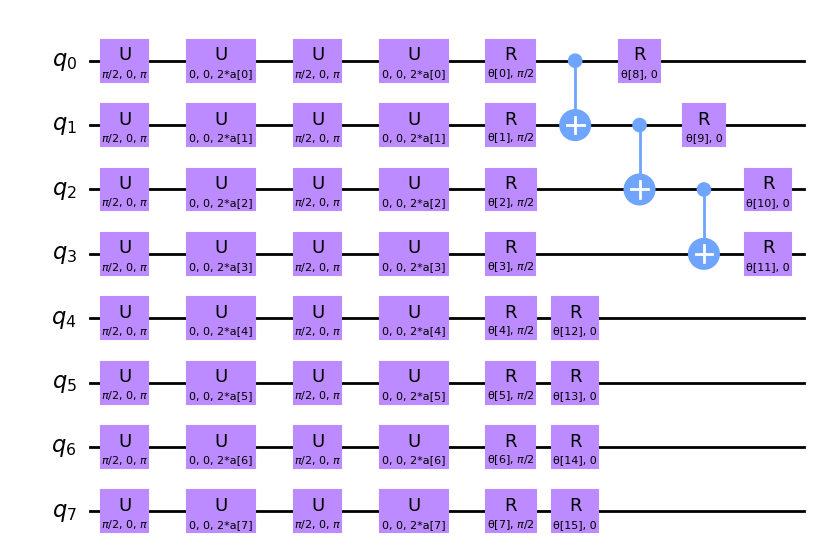

In [14]:
# QNN ansatz
ansatz = qnn_circuit

# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)

# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

We must now define an observable, so we can use it in our cost function. We will obtain an expectation value for this observable using Estimator. If we have selected a good, problem-motivated ansatz, then each qubit will contain information relevant to classification. One can add layers to combine information onto fewer qubits (called a *convolutional layer*), such that measurements are only needed on a subset of the qubits in the circuit (as in convolutional neural networks). Or one can measure some attribute from each qubit. Here we will opt for the latter, so we include a `Z` operator for each qubit. There is nothing unique about choosing $Z$, but it is well motivated:

*   This is a binary classification task, and a measurement of $Z$ can yield two possible outcomes.
*   The eigenvalues of $Z$ ($\pm 1$) are reasonably well separated, and result in an estimator outcome in interval \[-1, +1], where 0 can simply be used as a cutoff value.
*   It is straightforward to measure in Pauli Z basis with no extra gate overhead.

So, Z is a very natural choice.



In [15]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])

In [17]:
observable 

SparsePauliOp(['ZZZZZZZZ'],
              coeffs=[1.+0.j])

We have our quantum circuit and the observable we want to estimate. Now we need a few things in order to run and optimize this circuit. First, we need a function to run a forward pass. Note that the function below takes in the `input_params` and `weight_params` separately. The former is the set of static parameters describing the data in an image, and the latter is the set of variable parameters to be optimized.



In [20]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator


def forward(
    circuit: QuantumCircuit,
    input_params: np.ndarray,
    weight_params: np.ndarray,
    estimator: BaseEstimatorV2,
    observable: BaseOperator,
) -> np.ndarray:
    """
    Forward pass of the neural network.

    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive.
        observable: a single observable to compute the expectation over.

    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs

    return expectation_values

### Loss function

Next, we need a loss function to calculate the difference between the predicted and calculated values of the labels. The function will take in the labels predicted by the algorithm and the correct labels and return the mean squared difference. There any many different loss functions. Here, MSE is an example that we chose.



In [19]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).

    prediction: predictions from the forward pass of neural network.
    target: true labels.

    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError("input should be 1d-array")

Let us also define a slightly different loss function that is a function of the variable parameters (weights), for use by the classical optimizer. This function only takes the ansatz parameters as input; other variables for the forward pass and the loss are set as global parameters. The optimizer will train the model by sampling different weights and attempting to lower the output of the cost/loss function.



In [21]:
def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.

    weight_params: ansatz parameters to be updated by the optimizer.

    output: MSE loss.
    """
    predictions = forward(
        circuit=circuit,
        input_params=input_params,
        weight_params=weight_params,
        estimator=estimator,
        observable=observable,
    )

    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)

    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

Above we referred to using a classical optimizer. When we get to searching through weights to minimize the cost function, we will use the optimizer COBYLA:



In [22]:
from scipy.optimize import minimize

We will set some initial global variables for the cost function.



In [23]:
# Globals
circuit = full_circuit
observables = observable
# input_params = train_images_batch
# target = train_labels_batch
objective_func_vals = []
iter = 0

In [24]:
observables

SparsePauliOp(['ZZZZZZZZ'],
              coeffs=[1.+0.j])

## Qiskit Patterns Step 2: Optimize problem for quantum execution

We start by selecting a backend for execution. In this case, we will use the least-busy backend.



In [25]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

qiskit_runtime_service.__init__:WARNING:2026-02-06 16:44:48,027: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-06 16:44:48,873: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2026-02-06 16:44:52,225: Using instance: open-instance, plan: open


ibm_torino


Here we optimize the circuit for running on a real backend by specifying the optimization\_level and adding dynamical decoupling. The code below generates a pass manager using preset pass managers from qiskit.transpiler.



In [26]:
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target

pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)

Now we use the pass manager on the circuit. The layout changes that result must be applied to the observable as well. For very large circuits, the heuristics used in circuit optimization may not always yield the best and shallowest circuit. In those cases, it makes sense to run such pass managers several times and use the best circuit. We will see this later when we scale up our calculation.



In [27]:
circuit_ibm = pm.run(full_circuit)
observable_ibm = observable.apply_layout(circuit_ibm.layout)

## Qiskit Patterns Step 3: Execute using Qiskit Primitives

### Loop over the dataset in batches and epochs

We first implement the full algorithm using a simulator for cursory debugging and for estimates of error. We can now go over the entire dataset in batches in desired number of epochs to train our quantum neural network.



In [28]:
from qiskit.primitives import StatevectorEstimator as Estimator

batch_size = 140
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(
            mse_loss_weights, weight_params, method="COBYLA", options={"maxiter": 100}
        )
        weight_params = res["x"]

Epoch: 0, batch: 0
Iter: 0, loss: 1.0002309063537163
Iter: 50, loss: 0.9910034423915757


## Qiskit Patterns Step 4: Post-process, return result in classical format

### Testing and accuracy

We now interpret the results from training. We first test the training accuracy over the training set.



In [29]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer

estimator = Estimator()
# estimator = Estimator(backend=backend)

pred_train = forward(circuit, np.array(train_images), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)

accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[-1.07806742e-01  6.13858034e-02  4.88889517e-01 -5.41712363e-03
  2.31673659e-02 -6.35621634e-02 -2.93639980e-02 -1.16960293e-01
 -2.27045285e-01  3.47143847e-02 -4.34058731e-02  6.85959275e-02
  8.84012236e-04  2.27796482e-02 -3.47623501e-01  2.83825760e-02
 -3.47907576e-02 -1.45786585e-01 -4.69533007e-01 -1.82567961e-02
  1.28817243e-02 -1.21096334e-01 -3.91629501e-02 -3.22499359e-02
 -3.00525480e-03  3.64481144e-01  3.46037115e-02  5.12956201e-02
  4.50301723e-02  4.60529753e-03  4.05152080e-01 -8.78057641e-03
  6.60525998e-02  9.46294901e-02 -6.25719669e-02  3.41390986e-02
  2.40935012e-01  5.01122603e-02 -1.84654103e-02 -4.29890934e-01
 -2.89662767e-01  9.80257522e-02  1.74880477e-03  2.70065669e-02
  2.78388953e-01 -3.71069404e-01 -9.35074411e-03 -2.40493738e-02
  1.91052334e-02  6.61345076e-02  2.26706244e-03  2.32049920e-01
  6.98402216e-02 -2.75758526e-01  9.08902060e-03 -1.66811583e-02
  4.50958752e-03 -5.04659680e-02 -1.31891331e-03 -1.40589079e-02
 -1.07686363e-02  2.85093

The training accuracy is only $60%$, which is definitely not good. It is hard to imagine that the model's performance on the test set could be any better. Let's verify.



In [30]:
pred_test = forward(circuit, np.array(test_images), res["x"], estimator, observable)
# pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)

print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)

accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[ 0.03490544  0.03185024 -0.03818344  0.25266111  0.00792563 -0.51590529
 -0.02111715 -0.15116484  0.04626771  0.02426528  0.04657796 -0.03113558
  0.02293938  0.19400836  0.00329491  0.03525167 -0.00349979 -0.1225299
  0.13400674  0.02368346  0.28452681  0.03545407 -0.00502367 -0.10460012
  0.10591551  0.06649062 -0.05393373 -0.02300524  0.0056465  -0.09439755
  0.06771526 -0.07226252 -0.10675784 -0.01806446  0.00150743  0.1720385
 -0.14832903  0.03214366 -0.05805016 -0.00734088 -0.08244864 -0.01978241
  0.16975198 -0.02933303 -0.0082598  -0.01845949  0.19266379  0.17243566
 -0.02712035  0.02130188 -0.25076566  0.0100313  -0.10234677 -0.09672355
  0.04818503 -0.01241683  0.2933495  -0.02171279 -0.00102982 -0.01206131]
[ 1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1. -1.
  1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1.  1.
 -1.  1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1. -1. -1.
  1. -1.  1. -1. -1. -1.]
[-1, -1, 1, 1, -1, -1, 1, 

The model is not classifying these data well. We should ask why this is, and in particular, we should check:

*   Did we stop the training too soon? Were more optimization steps needed?
*   Did we construct a bad ansatz? This could mean a lot of things. When we work on real quantum computers, circuit depth will be a major consideration. The number of parameters is also potentially important, as is the entangling between qubits.
*   Combining the two above, did we construct an ansatz with too many parameters to be trainable?

We can start by checking for convergence in the optimization:



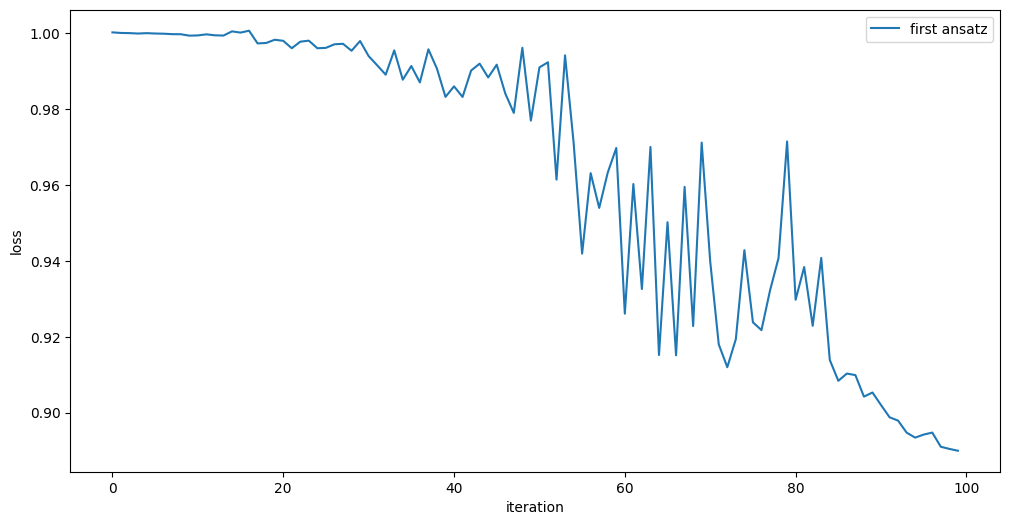

In [31]:
obj_func_vals_first = objective_func_vals
# import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

We might try extending the optimization steps to make sure the optimizer didn't just get stuck in a local minimum in parameter space. But it looks fairly converged. Let's take a closer look at the images that were *not* classified correctly, and see if we can understand what is happening.



In [32]:
missed = []
for i in range(len(test_labels)):
    if pred_test_labels[i] != test_labels[i]:
        missed.append(test_images[i])
print(len(missed))

24


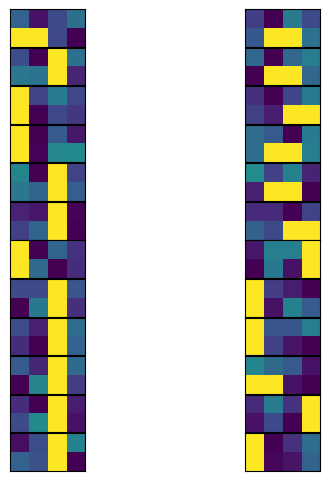

In [33]:
fig, ax = plt.subplots(12, 2, figsize=(6, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(len(missed)):
    ax[i // 2, i % 2].imshow(
        missed[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.02, hspace=0.025)

Here we can see that the vast majority of the wrongly-classified images have a vertical line. Something about our model is failing to capture information about those. You may have seen this coming, based on the first variational circuit. Let's look at it more closely.

## Improving the model

### Step 1 revisited

In mapping our problem to a quantum circuit, we should have explicitly thought about the how the information in adjacent pixels determines class. In order to identify horizontal lines, we want to know "if pixel $i$ is yellow, is pixel $i+1$ yellow" for all the pixels across each row. We also want to know about vertical lines. But since the classification is binary, one could imagine simply saying that if such a horizontal line is *not* detected, then it is a vertical line. Our previous variational circuit contained CNOT gates between qubits (and therefore pixels) 0 and 1, 1 and 2, and 2 and 3. That covers any horizontal lines across the top of the image, but it does not directly detect vertical lines, nor does it completely detect horizontal lines, as it ignores the lower row. To fully detect all horizontal lines, we would want to have a similar set of CNOT gates between qubits (pixels) 4 and 5, 5 and 6, and 6 and 7. We could keep in mind that adding CNOT gates between qubits corresponding to vertical lines (like 0 and 4, or 2 and 6) may also be useful. But we will first check whether it is sufficient to detect that there *is* or *is not* a horizontal line.



5
2+ qubit depth: 3


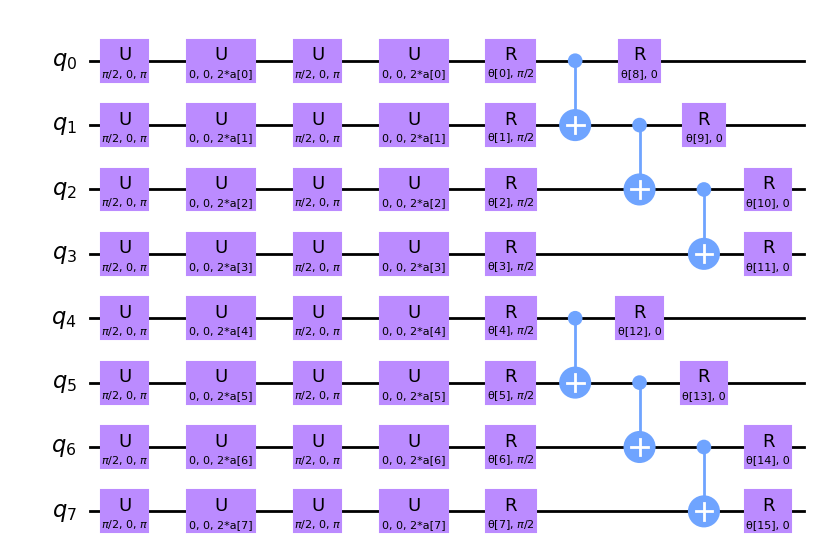

In [34]:
# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)

# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * size)

# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)

# Here is an extended list of qubit pairs between which we want CNOT gates. This now covers all pixels connected by horizontal lines.
qnn_cnot_list = [[0, 1], [1, 2], [2, 3], [4, 5], [5, 6], [6, 7]]

for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])

# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size + i], i)

# Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)

# Combine the feature map and variational circuit
ansatz = qnn_circuit

# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)

# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

We have not increased the depth of the circuit. Let's see if we have increased its ability to model our images.

### Step 2 revisited

We will need to transpile this new circuit for running on a real quantum backend. Let's skip this step for now to see if our revision of the variational circuit has had the desired effect on simulators. We will go deeper into transpilation in the next subsection.

### Step 3 revisited

We now apply the updated model to our training data.



In [35]:
from qiskit.primitives import StatevectorEstimator as Estimator

batch_size = 140
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(
            mse_loss_weights, weight_params, method="COBYLA", options={"maxiter": 100}
        )
        weight_params = res["x"]

Epoch: 0, batch: 0
Iter: 0, loss: 1.0049762969140237
Iter: 50, loss: 0.9610166111578138


### Step 4 revisited

Let's start by checking whether our optimizer fully converged.



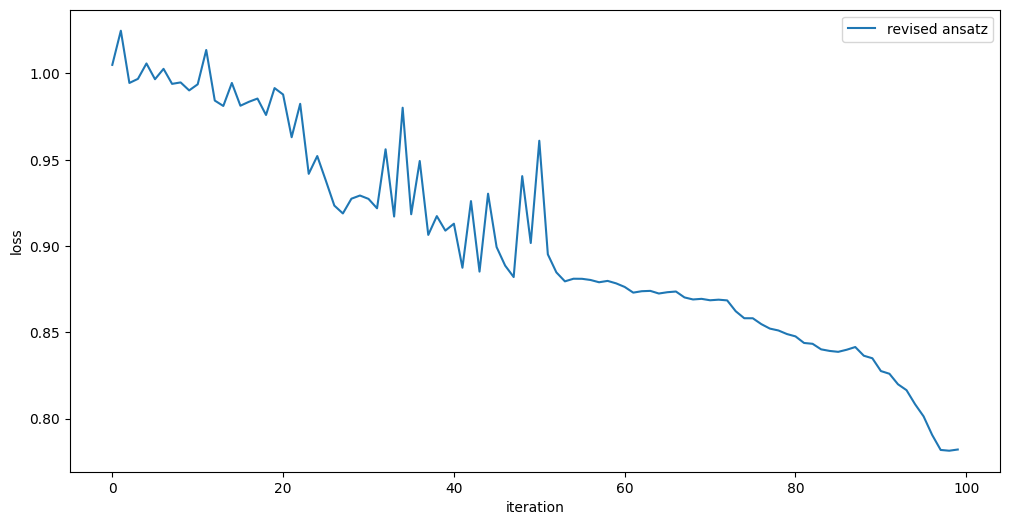

In [36]:
obj_func_vals_revised = objective_func_vals
# import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_revised, label="revised ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

This does not appear fully converged, as the loss function has not remained roughly level for substantially many steps. But the loss function is already \~60% lower than when using the previous variational circuit. If this were a research project, we would want to ensure full convergence. But for the purposes of exploration, this is sufficient. Let's check the accuracy on our training and testing data.



In [37]:
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer

estimator = Estimator()
# estimator = Estimator(backend=backend)

pred_train = forward(circuit, np.array(train_images), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)

accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[ 0.17588365  0.06358946  0.03154715  0.40568015 -0.26663654  0.35052378
  0.32532118  0.42179424 -0.12503935  0.01735073  0.34210006  0.03982966
  0.22643087 -0.4412831  -0.08404207 -0.21145139 -0.0864077  -0.08422211
  0.1610014   0.16197725  0.40828044 -0.14028519  0.12610441  0.33568985
 -0.21658925  0.14599275  0.2047188   0.27508696  0.38082561 -0.07229336
  0.01794865  0.29048418 -0.10297829  0.12442964  0.38024615  0.17366051
  0.06349612  0.27704119 -0.13239334 -0.02905743  0.03690951  0.18908208
  0.31179867 -0.45557033  0.0577176  -0.10626097  0.28010561  0.23700008
 -0.16567916  0.15686607  0.12601319  0.23702745  0.12737872 -0.14154204
  0.13267215  0.39800623  0.03006156  0.46442971 -0.21106578 -0.34238585
 -0.10174681  0.21789043  0.08702818 -0.1833671   0.32475031  0.2210001
  0.38867033 -0.10543421  0.09170983  0.45790369  0.09308404  0.2297307
  0.38493105  0.3522148  -0.03609128  0.0977109   0.20883459  0.07064556
  0.18794959  0.16861158  0.30113559  0.45925807  0.4

In [38]:
pred_test = forward(circuit, np.array(test_images), res["x"], estimator, observable)
# pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)

print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)

accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[ 0.15991126 -0.38271809  0.16161486  0.04462364 -0.22646557 -0.0807667
  0.47175973  0.00123989  0.09548693 -0.29120313  0.02120809  0.2205051
  0.27667248  0.01682459 -0.16974311  0.1939437  -0.36231285  0.1744752
  0.36515602  0.17900844  0.14718311 -0.11755908  0.07757464  0.2714839
  0.01625922 -0.29012097  0.33790635  0.03022243  0.35925687  0.25999274
  0.14048379 -0.25958896  0.08768122  0.33258691  0.06325939  0.31244923
  0.20687033  0.10872432  0.30611549 -0.23099417  0.03384005 -0.18916946
  0.04495479  0.49401586  0.18620635 -0.10690734  0.12783912  0.25469493
  0.26001136  0.22831741  0.1465171   0.08602245  0.19535164  0.02265729
  0.15900032  0.30678305  0.05103284  0.39003678 -0.25936609  0.29612062]
[ 1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1.
  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.
  1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1.  1.]
[-1, -1, 1, 1, -1, -1, 1, -1

$100\%$ accuracy on both sets! Our suspicion about accurate detection of horizontal lines being sufficient was correct! Further, our mapping from required information about the pixels to the CNOT gates in the quantum circuit was effective. Let's now look at how this process scales for running on real quantum computers.



## Scaling and running on real quantum computers

### Data

Let us begin by increasing the size of our images. There is nothing special about the choice of a 6x6 grid, except that it exceeds the number of qubits (32) that we can simulate for circuits using non-Clifford gates.



In [39]:
# This code defines the images to be classified:

import numpy as np

# Total number of "pixels"/qubits
size = 36
# One dimension of the image (called vertical, but it doesn't matter). Must be a divisor of `size`
vert_size = 6
# The length of the line to be detected (yellow). Must be less than or equal to the smallest dimension of the image (`<=min(vert_size,size/vert_size)`
line_size = 6


def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((size - (line_size - 1) * vert_size, size))
    ver_array = np.zeros((round(size / vert_size) * (vert_size - line_size + 1), size))

    j = 0
    for i in range(0, size - 1):
        if i % (size / vert_size) <= (size / vert_size) - line_size:
            for p in range(0, line_size):
                hor_array[j][i + p] = np.pi / 2
            j += 1

    # Make two adjacent entries pi/2, then move down to the next row. Careful to avoid the "pixels" at size/vert_size - linesize, because we want to fold this list into a grid.

    j = 0
    for i in range(0, round(size / vert_size) * (vert_size - line_size + 1)):
        for p in range(0, line_size):
            ver_array[j][i + p * round(size / vert_size)] = np.pi / 2
        j += 1

    # Make entries pi/2, spaced by the length/rows, so that when folded, the entries appear on top of each other.

    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, len(hor_array))
            images.append(np.array(hor_array[random_image]))
            # Randomly select one of the several rows you made above.
        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, len(ver_array))
            images.append(np.array(ver_array[random_image]))
            # Randomly select one of the several rows you made above.

        # Create noise
        for i in range(size):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels


hor_size = round(size / vert_size)

Because quantum computing time is a precious commodity, we will use a very small training set, and very few optimization steps. This will be sufficient to demonstrate the workflow.



In [40]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
# Here we specify a very small data set. Increase for realism, but monitor use of quantum computing time.
images, labels = generate_dataset(10)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

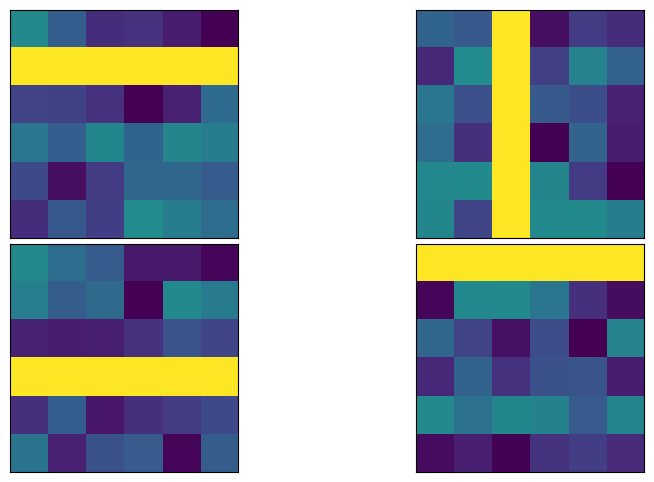

In [41]:
import matplotlib.pyplot as plt

# Generate a figure with nested images using subplots.

fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

### Step 1: Map the problem to a quantum circuit



In [42]:
from qiskit.circuit.library import z_feature_map

# One qubit per data feature
num_qubits = len(train_images[0])

# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = z_feature_map(num_qubits, parameter_prefix="a")

In [43]:
# This creates a circuit with the cxs in the compressed order.

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

qnn_circuit = QuantumCircuit(size)
params = ParameterVector("θ", length=2 * size)
for i in range(size):
    qnn_circuit.ry(params[i], i)

# CNOT gates between horizontally adjacent qubits.
for i in range(vert_size):
    for j in range(hor_size):
        if j < hor_size - 1:
            qnn_circuit.cx((i * hor_size) + j, (i * hor_size) + j + 1)

# CNOT gates between vertically adjacent qubits, likely not necessary based on our preliminary simulation.
#        if i<vert_size-1:
#            qnn_circuit.cx((i*hor_size)+j,(i*hor_size)+j+hor_size)
for i in range(size):
    qnn_circuit.rx(params[size + i], i)
qnn_circuit_large = qnn_circuit

print(qnn_circuit_large.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit_large.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)
# qnn_circuit_large.draw()

7
2+ qubit depth: 5


This is a reasonable two-qubit depth. We should be able to get high-quality results from a real quantum computer.



In [44]:
# Combine the feature map and variational circuit
ansatz = qnn_circuit

# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)

# Check the depth of the full circuit
print(full_circuit.decompose().depth())
print(
    f"2+ qubit depth: {full_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)

11
2+ qubit depth: 5


Because we are using the `z_feature_map`, which has no CNOT gates, adding the encoding layer does not increase our two-qubit depth. We can visualize the full circuit here.



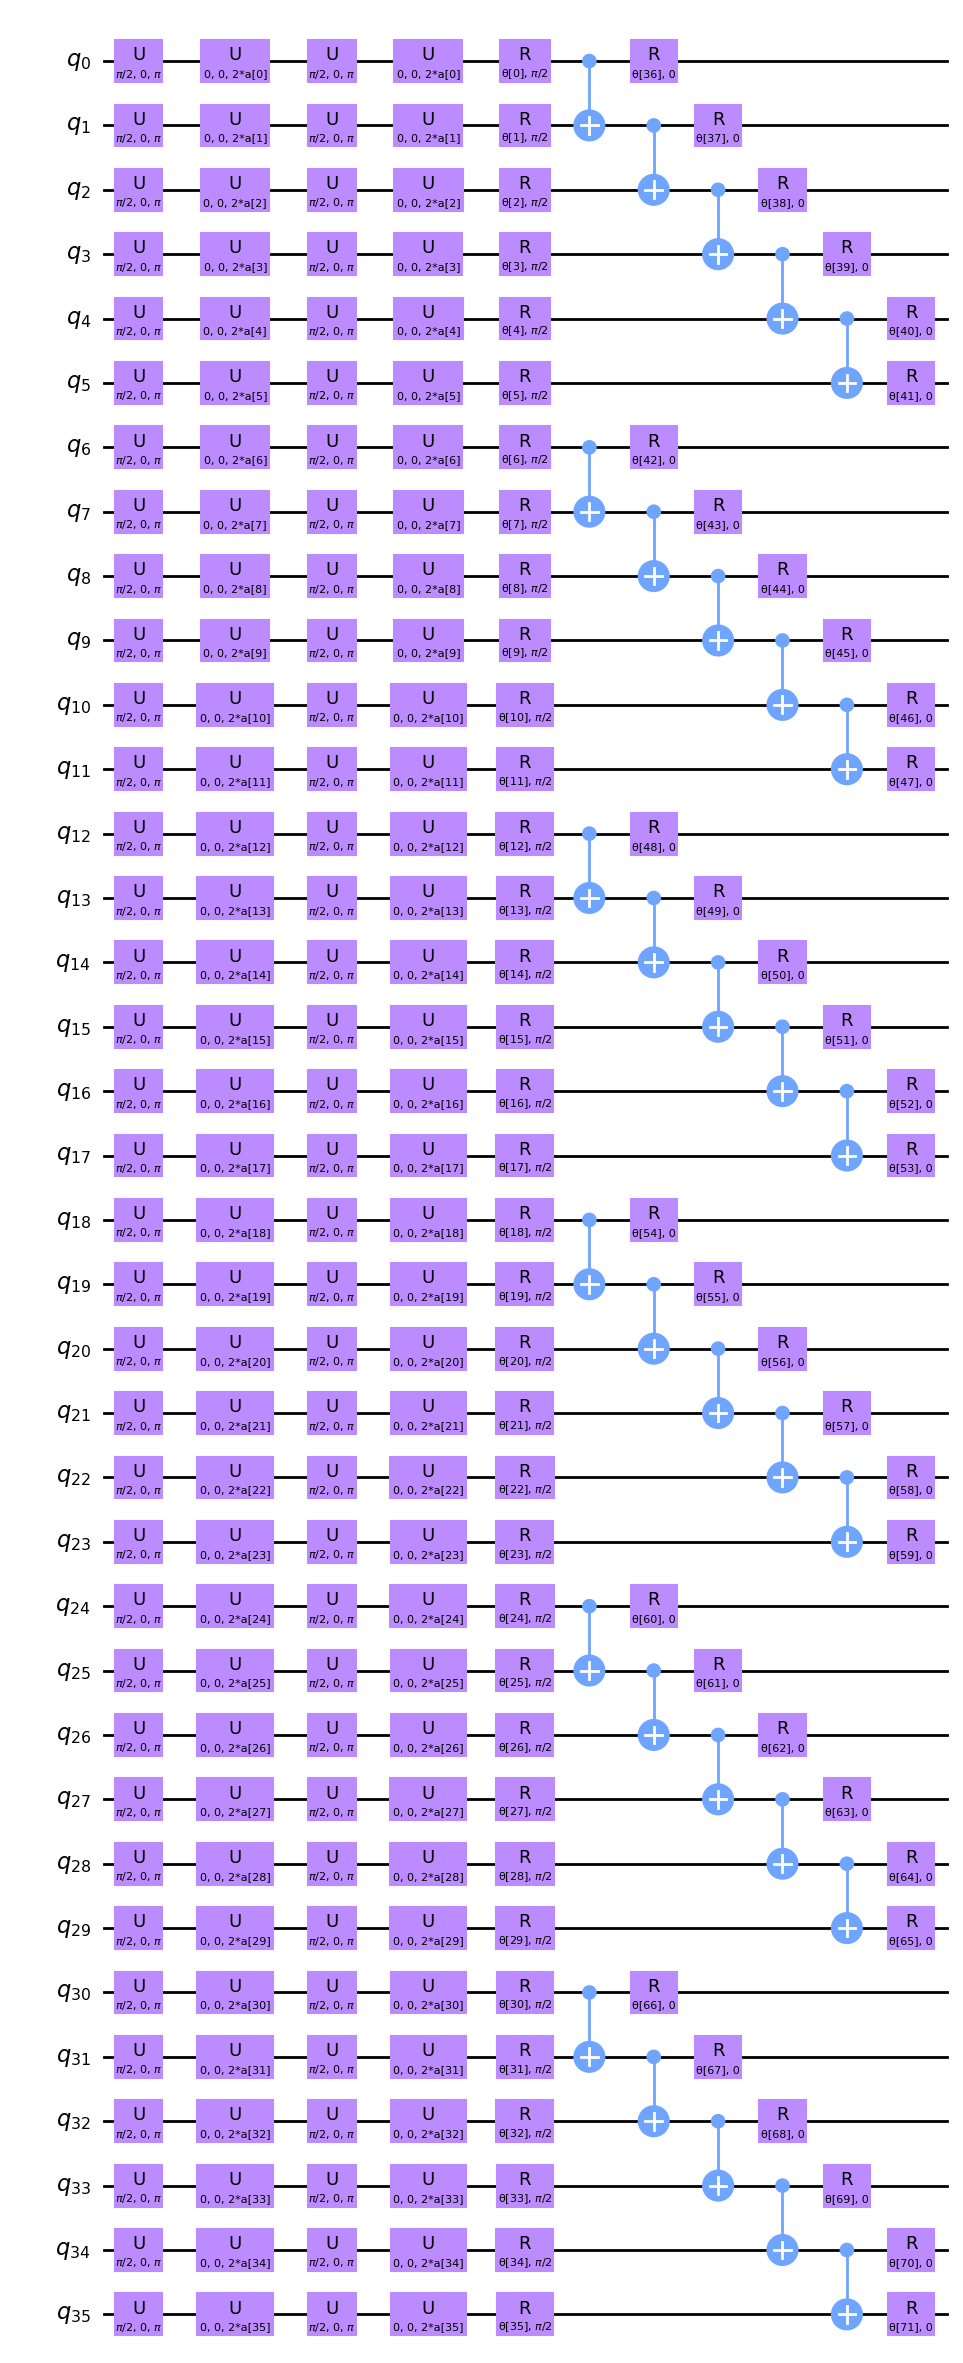

In [45]:
full_circuit.decompose().draw("mpl", style="clifford", idle_wires=False, fold=-1)

You may note that if minimizing two-qubit depth were of paramount importance, we could actually reduce it a bit by changing the order of the CNOTs. For example, the CNOTs on $q_{35}$ and $q_{34}$ could be moved to the left in the circuit diagram above, and could be placed directly below the CNOTs on $q_{30}$ and $q_{31}$, for example. For a two-qubit gate depth of 5, it isn't obvious that this will make a difference after transpilation, but it is something to keep in mind. If the order of the CNOT gates is important for logically matching the problem at hand, the depth here is fine. If the order of CNOTs is not critical to modeling the data structure in our images, then we could write a script to re-order these CNOT gates to minimize depth.

We also need to re-define our observable with our larger images:



In [46]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])

## Qiskit Patterns Step 2: Optimize problem for quantum execution

We start by selecting a backend for execution. In this case, we will use the least-busy backend.



In [47]:
from qiskit_ibm_runtime import QiskitRuntimeService

# To run on hardware, select the least busy quantum computer or specify a particular one.
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
# backend = service.backend("ibm_brisbaneane")

print(backend.name)

qiskit_runtime_service.__init__:WARNING:2026-02-06 16:50:33,028: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-06 16:50:33,867: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2026-02-06 16:50:37,143: Using instance: open-instance, plan: open


ibm_torino


Once again, we are defining a pass manager, with optimization level set to 3.



In [48]:
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target

pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)

Now we will apply the pass manager several times. For very wide or very deep circuits, there can be large variability in the transpiled two-qubit depths. For such circuits it is important to try the pass manager many times and use the best (shallowest) result.



In [49]:
# Try pass manager several times, since heuristics can return various transpilations on large circuits, and we want the shallowest.

transpiled_qcs = []
transpiled_depths = []
transpiled_2q_depths = []
for i in range(1, 10):
    circuit_ibm = pm.run(full_circuit)
    transpiled_qcs.append(circuit_ibm)
    transpiled_depths.append(circuit_ibm.decompose().depth())
    transpiled_2q_depths.append(
        circuit_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)
    )
    # print(i)

print(transpiled_depths)
print(transpiled_2q_depths)

# Use the shallowest

minpos = transpiled_2q_depths.index(min(transpiled_2q_depths))

[58, 58, 58, 58, 58, 58, 58, 58, 58]
[5, 5, 5, 5, 5, 5, 5, 5, 5]


We see that in this case, the transpiled two-qubit depth was always 10. There was minor variation in the single-qubit depth, and we will use the shallowest one. But on this 36-qubit circuit, this is not a critical improvement. We can visualize this transpiled circuit, although at this scale it becomes increasingly difficult to parse, visually.



In [50]:
circuit_ibm = transpiled_qcs[2]
observable_ibm = observable.apply_layout(circuit_ibm.layout)
print(circuit_ibm.decompose().depth())
print(
    f"2+ qubit depth: {circuit_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)

58
2+ qubit depth: 5


## Qiskit Patterns Step 3: Execute using Qiskit Primitives

In order to limit time used on real quantum computers, we will only carry out a few optimization steps here, and we are doing so on a very small training set. But the scaling of this to more optimization steps and larger testing data sets should be clear from instructions throughout the lesson.



In [51]:
# This was run on an Eagle r3 processor on 10-4-24, and took 7 min.

from qiskit_ibm_runtime import EstimatorV2 as Estimator, Session

batch_size = 7
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = circuit_ibm
observable = observable_ibm
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
# weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
# Or re-load weights from a previous calculation
weight_params = np.array(
    [
        3.35330497,
        5.97351416,
        4.59925358,
        3.76148219,
        0.98029403,
        0.98014248,
        0.3649501,
        6.44234523,
        3.77691701,
        4.44895122,
        0.12933619,
        6.09412333,
        5.23039137,
        1.33416598,
        1.14243996,
        1.15236452,
        1.91161039,
        3.2971419,
        3.71399059,
        1.82984665,
        3.84438512,
        0.87646578,
        1.83559896,
        2.30191935,
        2.86557222,
        4.93340606,
        1.25458737,
        3.23103027,
        3.72225051,
        0.29185655,
        3.81731689,
        1.07143467,
        0.40873121,
        5.96202367,
        6.067245,
        5.07931034,
        1.91394476,
        0.61369199,
        4.2991629,
        2.76555968,
        0.76678884,
        3.11128829,
        0.21606945,
        5.71342859,
        1.62596258,
        4.16275028,
        1.95853845,
        3.26768375,
        3.43508199,
        1.1614748,
        6.09207989,
        4.87030317,
        5.90304595,
        5.62236606,
        3.75671636,
        5.79230665,
        0.55601479,
        1.23139664,
        0.28417144,
        2.04411075,
        2.44213144,
        1.70493625,
        5.20711134,
        2.24154726,
        1.76516358,
        3.40986006,
        0.88545302,
        5.04035228,
        0.46841551,
        6.2007935,
        4.85215699,
        1.24856745,
    ]
)

# Running in a session avoids repeated queuing. This is available to Premium Plan, Flex Plan, and On-Prem (IBM Quantum Platform API) Plan users.

with Session(backend=backend) as session:
    estimator = Estimator(mode=session, options={"resilience_level": 1})

    for epoch in range(num_epochs):
        for i in range((num_samples - 1) // batch_size + 1):
            print(f"Epoch: {epoch}, batch: {i}")
            start_i = i * batch_size
            end_i = start_i + batch_size
            train_images_batch = np.array(train_images[start_i:end_i])
            train_labels_batch = np.array(train_labels[start_i:end_i])
            input_params = train_images_batch
            target = train_labels_batch
            iter = 0
            # We can increase maxiter to do a full optimization.
            res = minimize(
                mse_loss_weights,
                weight_params,
                method="COBYLA",
                options={"maxiter": 20},
            )
            weight_params = res["x"]
session.close()

# Open users can carry out the same calculation using a batch, but repeated queuing is possible.
# from qiskit_ibm_runtime import Batch

# with Batch(backend=backend) as batch:
#    estimator = Estimator(
#        mode=batch, options={"resilience_level": 1}
#    )
#
#    for epoch in range(num_epochs):
#        for i in range((num_samples - 1) // batch_size + 1):
#            print(f"Epoch: {epoch}, batch: {i}")
#            start_i = i * batch_size
#            end_i = start_i + batch_size
#            train_images_batch = np.array(train_images[start_i:end_i])
#            train_labels_batch = np.array(train_labels[start_i:end_i])
#            input_params = train_images_batch
#            target = train_labels_batch
#            iter = 0
#            # We can increase maxiter to do a full optimization.
#            res = minimize(
#                mse_loss_weights,
#                weight_params,
#                method="COBYLA",
#                options={"maxiter": 20},
#            )
#            weight_params = res["x"]
# batch.close()

RequestsApiError: '400 Client Error: Bad Request for url: https://quantum.cloud.ibm.com/api/v1/sessions. {"errors":[{"code":1352,"message":"You are not authorized to run a session when using the open plan.","solution":"Create an instance of a different plan type or use a different [execution mode](https://quantum.cloud.ibm.com/docs/guides/execution-modes).","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"34bc5aaa-d2d4-4498-9225-e8e5b26b488f"}\n'

It is recommended that you save the weight parameters returned from this computation, should you decide to iterate further.



In [85]:
weight_params

array([3.35330497, 6.97351416, 5.59925358, 3.76148219, 0.98029403,
       0.98014248, 0.3649501 , 6.44234523, 3.77691701, 4.44895122,
       1.12933619, 7.09412333, 5.23039137, 1.33416598, 1.14243996,
       1.15236452, 1.91161039, 3.2971419 , 3.71399059, 1.82984665,
       3.84438512, 0.87646578, 1.83559896, 2.30191935, 2.86557222,
       4.93340606, 1.25458737, 3.23103027, 3.72225051, 0.29185655,
       3.81731689, 1.07143467, 0.40873121, 5.96202367, 6.067245  ,
       5.07931034, 1.91394476, 0.61369199, 4.2991629 , 2.76555968,
       0.76678884, 3.11128829, 0.21606945, 5.71342859, 1.62596258,
       4.16275028, 1.95853845, 3.26768375, 3.43508199, 1.1614748 ,
       6.09207989, 4.87030317, 5.90304595, 5.62236606, 3.75671636,
       5.79230665, 0.55601479, 1.23139664, 0.28417144, 2.04411075,
       2.44213144, 1.70493625, 5.20711134, 2.24154726, 1.76516358,
       3.40986006, 0.88545302, 5.04035228, 0.46841551, 6.2007935 ,
       4.85215699, 1.24856745])

We can plot these first few optimization steps, although we would not expect any convergence after just a few optimization steps. These curves have been relatively flat for the first few steps, even using simulators. We should note, however, that the optimization currently has 72 free parameters. This can be reduced by at least a factor of 2-3 without compromising results by, for example, parameterizing qubits with data corresponding to a subset of full rows and columns. Indeed, the parameter space should be reduced before spending more quantum computing time on minimizing the loss function.



In [ ]:
obj_func_vals_qc = objective_func_vals
# import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_qc, label="revised ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

<Image src="/learning/images/courses/quantum-machine-learning/qvc-qnn/extracted-outputs/d8244ff1-a7c5-46e1-87b1-e20b506ef4d8-0.avif" alt="Output of the previous code cell" />

### Closing

To recap, in this lesson we learned the workflow for binary classification of images using a quantum neural network. Some key considerations in each Qiskit patterns step were:

**Step 1:** Map the problem to a quantum circuit

*   Load training data. This could be done "by hand" or using a pre-built feature map like `z_feature_map`.
*   Construct an ansatz containing rotation and entanglement layers that are appropriate for your problem.
*   Monitor circuit depth to ensure quality results on quantum computers.

**Step 2:** Optimize problem for quantum execution

*   Select a backend, often the least busy one.
*   Use a pass manager to transpile both the circuit and the observables to the architecture of the chosen backend.
*   For very deep or wide circuits, transpile multiple times, and select the shallowest circuit.

**Step 3:** Execute using Qiskit (Runtime) Primitives

*   Carry out preliminary trials on simulators to debug and optimize your ansatz.
*   Execute on an IBM® quantum computer.

**Step 4:** Post-process, return result in classical format

*   Calculate model accuracy on training data, and on testing data.
*   Monitor convergence of the classical optimization.



## References

\[1] [https://arxiv.org/abs/2405.00781](https://arxiv.org/abs/2405.00781)



© IBM Corp., 2017-2026